In [10]:
import torch
import torch.nn as nn
from torchinfo import summary
from scripts import muat_datasets
from pathlib import Path
from torchvision.transforms import v2
import torchvision

In [11]:
data_path = Path('datasets')
train_dir, test_dir = muat_datasets.muat_data(data_path)

Path dataset sudah benar!


In [12]:
train_dir, test_dir

(WindowsPath('datasets/train'), WindowsPath('datasets/test'))

Direktori gambar: datasets\train\red_rot\redrot (434).jpeg
Class gambar: red_rot
Tinggi gambar: 1040
Lebar gambar: 493


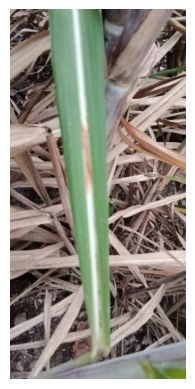

In [13]:
from scripts import visualization

visualization.cek_gambar(data_path)

In [14]:
train_transform = v2.Compose([
    v2.Resize(size = [224, 224]),
    # v2.Grayscale(num_output_channels = 1),
    v2.AutoAugment(policy = v2.AutoAugmentPolicy.IMAGENET, interpolation = v2.InterpolationMode.BICUBIC),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

test_transform = v2.Compose([
    v2.Resize(size = [224, 224]),
    # v2.Grayscale(num_output_channels = 1),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

weights = torchvision.models.ViT_B_16_Weights.DEFAULT
auto_transforms = weights.transforms()

In [15]:
train_data_loader, test_data_loader, class_names = muat_datasets.dataLoader(train_dir = train_dir,
                                                                            test_dir = test_dir,
                                                                            batch_size = 32, num_workers = 4,
                                                                            train_transform = auto_transforms,
                                                                            test_transform = auto_transforms)
train_data_loader, test_data_loader, class_names

Membuat DataLoader dengan ukuran batch 32 dan 4 workers.


(<torch.utils.data.dataloader.DataLoader at 0x1fa1384aa20>,
 ['healthy', 'mosaic', 'red_rot', 'rust', 'yellow'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape gambar: torch.Size([3, 224, 224])
Class gambar (bentuk angka): 0


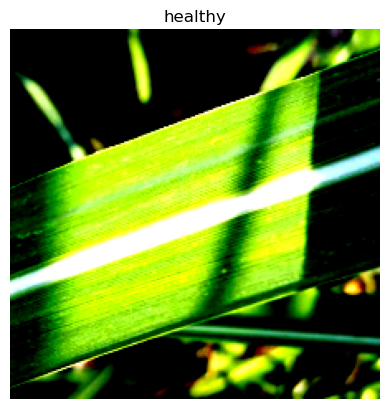

In [16]:
image_batch, label_batch = next(iter(test_data_loader))

visualization.cek_gambar_dl(image_batch = image_batch, label_batch = label_batch, class_names = class_names)

# LOAD SWIN

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [18]:
model = torchvision.models.vit_b_16(weights = weights).to(device)

In [22]:
for param in model.parameters():
    param.requires_grad = False

torch.manual_seed(7)
torch.cuda.manual_seed(7)

output_shape = len(class_names)

model.heads = torch.nn.Sequential(
    torch.nn.Linear(in_features=768, 
                    out_features = output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [23]:
PATH = Path('models')
MODEL_NAME = 'ViT-B16_daun_tebu_AutoTransform_Norm.pth'

SAVE_PATH = PATH/MODEL_NAME

In [24]:
model.load_state_dict(torch.load(f=SAVE_PATH))

<All keys matched successfully>

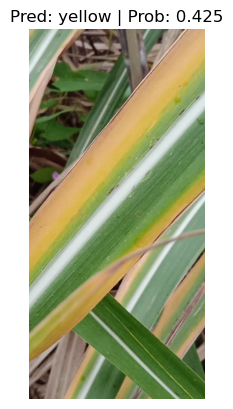

In [58]:
from scripts import prediksi

custom_img_path = Path('datasets/test/yellow/yellow (50).jpeg')
prediksi.pred_gambar(model = model,
                image_path = custom_img_path,
                class_names=class_names,
                transform = test_transform,
                device = device)

  0%|          | 0/16 [00:00<?, ?it/s]

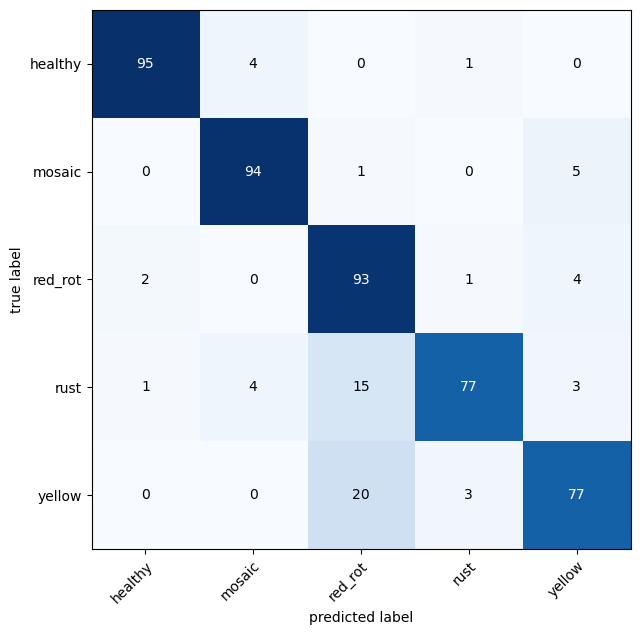

In [27]:
prediksi.confusion_matrix(
    model = model,
    test_dataloader = test_data_loader,
    device = device,
    class_names = class_names
)